In [1]:
import yfinance as yf
import pandas as pd
import os
import random
import gymnasium
from gymnasium import Env
from gymnasium.spaces import Discrete,Box
import numpy as np
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO,A2C,DDPG
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise
import torch
import random

In [ ]:
if not os.path.exists("nifty_data_2010_2019"):
    os.makedirs("nifty_data_2010_2019")

survivors=[
    "ACC.NS","AMBUJACEM.NS","AXISBANK.NS","BHARTIARTL.NS","BPCL.NS",
    "CIPLA.NS","GAIL.NS","GRASIM.NS","HCLTECH.NS","HDFCBANK.NS",
    "HEROMOTOCO.NS","HINDALCO.NS","HINDUNILVR.NS","ICICIBANK.NS","INFY.NS",
    "ITC.NS","LT.NS","M&M.NS","MARUTI.NS","NTPC.NS","ONGC.NS",
    "POWERGRID.NS","RELIANCE.NS","SBIN.NS","SUNPHARMA.NS","TCS.NS",
    "TATASTEEL.NS","WIPRO.NS","ABB.NS","BHEL.NS",
    "DLF.NS","IDEA.NS","JPASSOCIAT.NS","JINDALSTEL.NS",
    "PNB.NS","RELINFRA.NS","RPOWER.NS","SAIL.NS","SIEMENS.NS",
    "SUZLON.NS","TATAPOWER.NS","UNITECH.NS","RCOM.NS"
]

for ticker in survivors:
      df=yf.download(ticker,start="2010-01-01",end="2020-01-01")
      if not df.empty:
           filename=f"nifty_data_2010_2019/{ticker}.csv"
           df.to_csv(filename)
           print(f"Success:{ticker}")


In [8]:
path=r"D:\Data Science and ML\Reinforcement Learning\Midterm Submission\Stock_Price_Prediction\nifty_data_2010_2019"
for filename in os.listdir(path):
   filepath=os.path.join(path,filename)
   df=pd.read_csv(filepath)
   df=df.dropna()
   df.to_csv(filepath,index=False)

## Adding Price Features

In [10]:
path=r"D:\Data Science and ML\Reinforcement Learning\Midterm Submission\Stock_Price_Prediction\nifty_data_2010_2019"

if os.path.exists(path):
    for filename in os.listdir(path):
        if filename.endswith(".csv"):
            filepath=os.path.join(path,filename)
            df=pd.read_csv(filepath)
            df=df.iloc[1:].copy()

            if 'Price' in df.columns:
                df=df.rename(columns={'Price':'Date'})

            df['Date']=pd.to_datetime(df['Date'])
            df=df.set_index('Date')

            cols=['High','Low','Close']
            for c in cols:
                df[c]=pd.to_numeric(df[c],errors='coerce')

            df=df.dropna()

            df["Daily Return"]=df["Close"].pct_change()

            # MACD
            k_fast=df["Close"].ewm(span=12,adjust=False).mean()
            k_slow=df["Close"].ewm(span=26,adjust=False).mean()
            df["MACD"]=k_fast-k_slow

            # RSI
            delta=df["Close"].diff()
            gain=delta.where(delta>0,0)
            loss=-delta.where(delta<0,0)

            avg_gain=gain.ewm(alpha=1/14,adjust=False).mean()
            avg_loss=loss.ewm(alpha=1/14,adjust=False).mean()

            rs=avg_gain/avg_loss
            df["RSI"]=100-(100/(1+rs))

            # CCI
            tp=(df['High']+df['Low']+df['Close'])/3
            sma_tp=tp.rolling(window=20).mean()

            md=(tp-sma_tp).abs().rolling(window=20).mean()
            df["CCI"]=(tp-sma_tp)/(0.015*md)

            # ADX
            prev_close=df['Close'].shift(1)
            tr1=df['High']-df['Low']
            tr2=(df['High']-prev_close).abs()
            tr3=(df['Low']-prev_close).abs()
            tr=pd.concat([tr1,tr2,tr3],axis=1).max(axis=1)

            up_move=df['High']-df['High'].shift(1)
            down_move=df['Low'].shift(1)-df['Low']

            plus_dm=np.where((up_move>down_move) & (up_move>0),up_move,0.0)
            minus_dm=np.where((down_move>up_move) & (down_move>0),down_move,0.0)

            tr_smooth=tr.ewm(alpha=1/14,adjust=False).mean()
            plus_di=100*(pd.Series(plus_dm,index=df.index).ewm(alpha=1/14,adjust=False).mean()/tr_smooth)
            minus_di=100*(pd.Series(minus_dm,index=df.index).ewm(alpha=1/14,adjust=False).mean()/tr_smooth)

            dx=100*(abs(plus_di-minus_di)/(plus_di+minus_di))
            df["ADX"]=dx.ewm(alpha=1/14,adjust=False).mean()

            df=df.dropna()

            df.to_csv(filepath,index=True)

    print("All files updated with MACD,RSI,CCI,and ADX.")
else:
    print("Folder not found.")

All files updated with MACD,RSI,CCI,and ADX.


In [ ]:
f=pd.read_csv(r"D:\Data Science and ML\Reinforcement Learning\Midterm Submission\Stock_Price_Prediction\nifty_data_2010_2019\ABB.NS.csv")
f.head()

,Date,Close,High,Low,Open,Volume,Daily Return,MACD,RSI,CCI,ADX
0,2010-03-02,666.643555,685.812218,660.254038,685.812218,445384,-0.015228,-0.390713,41.986123,-67.446886,20.564921
1,2010-03-03,678.954285,681.424877,663.278582,668.773566,279846,0.018467,-0.518769,48.901066,-37.916279,20.179500
2,2010-03-04,681.424866,685.812365,673.927806,674.737170,179884,0.003639,-0.416103,50.184350,1.300686,19.390730
3,2010-03-05,700.465759,702.766013,679.848816,682.404634,449349,0.027943,1.188007,58.776935,83.020658,18.748102
4,2010-03-08,720.912292,723.808902,702.851112,707.110828,574636,0.029190,4.062313,65.632234,185.251961,19.386865


## Trading Environment

In [4]:
class StockTradingEnv(gymnasium.Env):
    def __init__(self,data,raw_data,stock_dim,initial_balance=1000000,transaction_cost_pct=0.001):
        super(StockTradingEnv,self).__init__()

        self.data=data
        self.raw_data=raw_data
        self.stock_dim=stock_dim
        self.initial_balance=initial_balance
        self.transaction_cost_pct=transaction_cost_pct
        self.h_max=1000 # Maximum shares to trade per step
        self.max_portfolio_value=initial_balance

        # Action Space
        self.action_space=spaces.Box(low=-1,high=1,shape=(self.stock_dim,),dtype=np.float32)

        # Observation Space:Balance+Holdings+Prices+Indicators
        num_features_per_stock=self.data.shape[2]
        self.obs_shape=1+self.stock_dim+(self.stock_dim*num_features_per_stock)
        self.observation_space=spaces.Box(low=-np.inf,high=np.inf,shape=(self.obs_shape,),dtype=np.float32)

        self.reset()

    def reset(self,seed=None):
        super().reset(seed=seed)
        self.day=0
        self.balance=self.initial_balance
        self.holdings=np.zeros(self.stock_dim)
        self.portfolio_value=self.initial_balance
        self.max_portfolio_value=self.initial_balance
        return self._get_observation(),{}

    def step(self,actions):

        done=self.day>=len(self.data)-1
        if done:
            return self._get_observation(),0,done,False,{}

        # Get current market prices
        current_prices=self.raw_data[self.day][:,0]

        # Interpret Actions
        delta_holdings=np.floor(actions*self.h_max).astype(int)
        transaction_cost=0

        for i in range(self.stock_dim):
            action_shares=delta_holdings[i]
            price=current_prices[i]

            # SELL
            if action_shares<0:
                # You can only sell what you currently own
                shares_to_sell=min(abs(action_shares),self.holdings[i])

                if shares_to_sell>0:
                    self.holdings[i]-=shares_to_sell
                    cash_in=shares_to_sell*price
                    cost=cash_in*self.transaction_cost_pct
                    self.balance+=(cash_in-cost)
                    transaction_cost+=cost

            # BUY
            elif action_shares>0:
                cost=action_shares*price*self.transaction_cost_pct
                total_cost=(action_shares*price)+cost

                # You can only buy if you have enough cash
                if self.balance>=total_cost:
                    self.holdings[i]+=action_shares
                    self.balance-=total_cost
                    transaction_cost+=cost

        self.day+=1
        next_prices=self.raw_data[self.day][:,0]

        # Reward=New Portfolio Value-Old Portfolio Value
        new_portfolio_value=self.balance+np.sum(next_prices*self.holdings)
        daily_return=(new_portfolio_value-self.portfolio_value)
        reward=daily_return 

        # Update for next step
        self.portfolio_value=new_portfolio_value

        return self._get_observation(),reward*5,done,False,{}

    def _get_observation(self):
        # The holdings and balance are scaled as tehy might overshadow the prices and indicators
        # The raw model was trained without scaling, the normed model was trained with scaling
        scaled_balance=self.balance/self.initial_balance
        scaled_holdings=self.holdings/self.h_max
        current_features=self.data[self.day].flatten()

        return np.concatenate(([scaled_balance],scaled_holdings,current_features)).astype(np.float32)

## Creating np array from DFs

In [ ]:
def merge_data(directory_path):
    required_features=['Close','MACD','RSI','CCI','ADX']

    merged_data={}

    print("Reading files...")
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            ticker=filename.replace(".csv","")
            filepath=os.path.join(directory_path,filename)

            df=pd.read_csv(filepath)
            df['Date']=pd.to_datetime(df['Date'])
            df=df.set_index('Date')

            try:
                df=df[required_features]
                merged_data[ticker]=df
            except KeyError as e:
                print(f"Skipping {ticker}:Missing columns {e}")

    all_dates=pd.Index([])
    for df in merged_data.values():
        all_dates=all_dates.union(df.index)

    all_dates=all_dates.sort_values()

    tickers_list=sorted(list(merged_data.keys()))
    num_stocks=len(tickers_list)
    num_features=len(required_features)
    num_timesteps=len(all_dates)

    final_array=np.zeros((num_timesteps,num_stocks,num_features))

    for i,ticker in enumerate(tickers_list):
        df=merged_data[ticker]

        df_reindexed=df.reindex(all_dates)

        df_reindexed=df_reindexed.ffill().bfill()

        final_array[:,i,:]=df_reindexed.values

    if np.isnan(final_array).any():
        final_array=np.nan_to_num(final_array)

    print(f"Final Data Shape:{final_array.shape}")
    final_array=final_array.astype(np.float32)
    return final_array,tickers_list

data_path=r"D:\Data Science and ML\Reinforcement Learning\Midterm Submission\Stock_Price_Prediction\nifty_data_2010_2019"
train_data,tickers=merge_data(data_path)


Reading files...
Final Data Shape:(2425, 43, 5)


## Data Normalization
- Using rolling norm to prevent data leakage into the train step

In [22]:
def rolling_norm(data,window=50):
  days,stocks,features=data.shape
  norm_data=np.zeros_like(data,dtype=np.float32)

  for i in range(stocks):
    for j in range(features):
      series=pd.Series(data[:,i,j])
      rolling=series.rolling(window=window,min_periods=1)
      mean=rolling.mean()
      std=rolling.std(ddof=0)
      norm_data[:,i,j]=(data[:,i,j]-mean)/(std+1e-10)

  return norm_data

In [ ]:
normed_data=rolling_norm(train_data)
np.save(r"D:\Data Science and ML\Reinforcement Learning\Midterm Submission\Stock_Price_Prediction\normed_data",normed_data)

In [24]:
train_data.shape

(2425, 43, 5)

## Model training

In [ ]:
train_end=int(len(normed_data)*0.90)

train_norm=normed_data[:train_end]
train_raw=train_data[:train_end]


env_train=StockTradingEnv(data=train_norm,raw_data=train_raw,stock_dim=len(tickers))

print("--- Starting PPO Training ---")
model_ppo=PPO(
    "MlpPolicy",
    env_train,
    verbose=1,
    learning_rate=0.0003,
    n_steps=2048,
    n_epochs=15,
    batch_size=64,
)

model_ppo.learn(total_timesteps=100000)
print("PPO Training Complete.")



## Best model with normalized data

--- Testing PPO on Unseen Future ---
PPO Return: 6.16%
PPO Sharpe: 0.4538
B&H Return: -9.81%


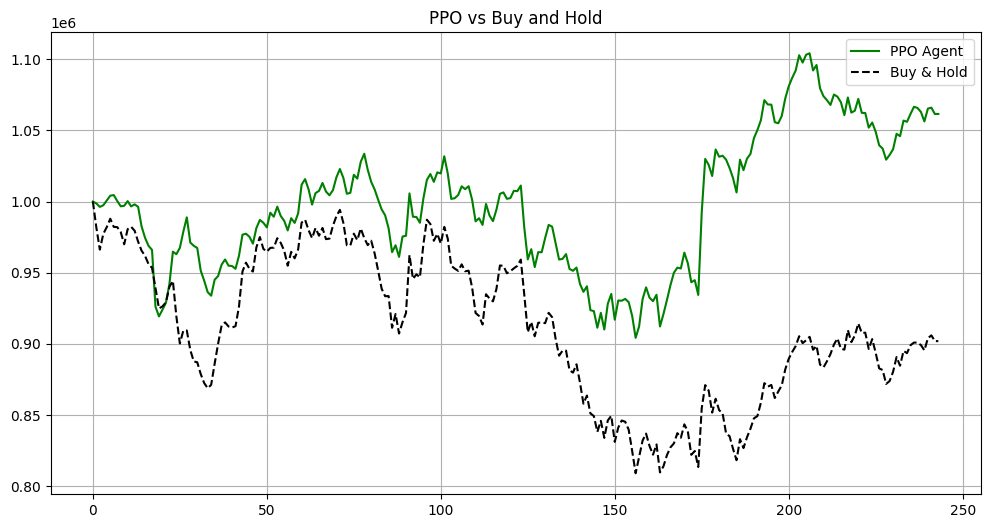

In [134]:
#-------------- Evaluation -------------------
print("--- Testing PPO on Unseen Future ---")

test_set_norm=normed_data[train_end:]
test_set_raw=train_data[train_end:]

env_test=StockTradingEnv(data=test_set_norm,raw_data=test_set_raw,stock_dim=len(tickers))

obs,_=env_test.reset()
done=False
portfolio_values=[env_test.initial_balance]
buy_and_hold_values=[env_test.initial_balance]

test_initial_prices=test_set_raw[0][:,0]
initial_cash=env_test.initial_balance
bnh_holdings=(initial_cash/len(tickers))/test_initial_prices

while not done:
    action,_=model_ppo.predict(obs,deterministic=True)
    obs,_,done,_,_=env_test.step(action)
    portfolio_values.append(env_test.portfolio_value)

    if env_test.day<len(test_set_raw):
        current_prices=test_set_raw[env_test.day][:,0]
        buy_and_hold_values.append(np.sum(current_prices*bnh_holdings))

# Metrics
portfolio_values=np.array(portfolio_values)
buy_and_hold_values=np.array(buy_and_hold_values)

def calculate_metrics(values,initial_val):
    cum_ret=((values[-1]-initial_val)/initial_val)*100
    daily_rets=np.diff(values)/values[:-1]
    sharpe=(np.mean(daily_rets)/np.std(daily_rets))*np.sqrt(252) if np.std(daily_rets) > 0 else 0
    return cum_ret,sharpe

cum_ret_ppo,sharpe_ppo_test=calculate_metrics(portfolio_values,initial_cash)
cum_ret_bnh,sharpe_bnh_test=calculate_metrics(buy_and_hold_values,initial_cash)


print(f"PPO Return: {cum_ret_ppo:.2f}%")
print(f"PPO Sharpe: {sharpe_ppo_test:.4f}")
print(f"B&H Return: {cum_ret_bnh:.2f}%")

plt.figure(figsize=(12,6))
plt.plot(portfolio_values,label='PPO Agent',color='green')
plt.plot(buy_and_hold_values,label='Buy & Hold',color='black',linestyle='--')
plt.title(f'PPO vs Buy and Hold')
plt.legend()
plt.grid(True)
plt.show()

## Saving Model

In [ ]:
import pickle
model_ppo.save(r"D:\Data Science and ML\Reinforcement Learning\Midterm Submission\Stock_Price_Prediction\ppo_model")
np.save(r"D:\Data Science and ML\Reinforcement Learning\Midterm Submission\Stock_Price_Prediction\train_data.npy",train_data)
np.save(r"D:\Data Science and ML\Reinforcement Learning\Midterm Submission\Stock_Price_Prediction\normed_data.npy",normed_data)

## Best model with raw data

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
--- Running Deterministic Evaluation ---

Metric          | PPO Agent    | Buy & Hold  
---------------------------------------------
Total Return    |      11.88% |      -9.81%
Sharpe Ratio    |     0.8586 |    -0.5193


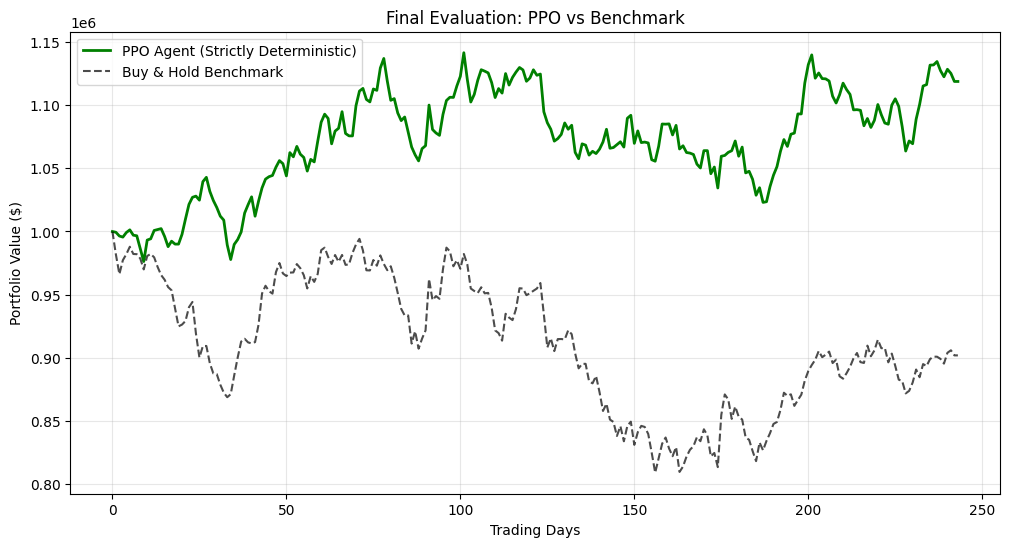

In [6]:
full_processed_data=np.load(r"D:\Data Science and ML\Reinforcement Learning\Midterm Submission\Stock_Price_Prediction\processed_data.npy")


train_end_idx=int(len(full_processed_data)*0.9)


eval_raw_data=full_processed_data[train_end_idx:]
eval_norm_data=full_processed_data[train_end_idx:]


env_test=StockTradingEnv(
    data=eval_norm_data,
    raw_data=eval_raw_data,
    stock_dim=43
)

model=PPO.load(r"D:\Data Science and ML\Reinforcement Learning\Midterm Submission\Stock_Price_Prediction\ppo_nifty_model_v1.zip",env=env_test)

obs,_=env_test.reset()
done=False

portfolio_values=[env_test.initial_balance]
buy_and_hold_values=[env_test.initial_balance]

test_initial_prices=eval_raw_data[0][:,0]
initial_cash=env_test.initial_balance
bnh_holdings=(initial_cash/43)/test_initial_prices

print("--- Running Deterministic Evaluation ---")

while not done:
    action,_=model.predict(obs,deterministic=True)

    obs,_,done,_,_=env_test.step(action)

    portfolio_values.append(env_test.portfolio_value)

    if env_test.day<len(eval_raw_data):
        current_prices=eval_raw_data[env_test.day][:,0]
        buy_and_hold_values.append(np.sum(current_prices*bnh_holdings))

portfolio_values=np.array(portfolio_values)
buy_and_hold_values=np.array(buy_and_hold_values)

def calculate_metrics(values,initial_val):
    cum_ret=((values[-1] - initial_val)/initial_val)*100
    daily_rets=np.diff(values)/(values[:-1])
    sharpe=(np.mean(daily_rets)/(np.std(daily_rets)+1e-10))*np.sqrt(252)
    return cum_ret,sharpe

cum_ret_ppo,sharpe_ppo=calculate_metrics(portfolio_values,initial_cash)
cum_ret_bnh,sharpe_bnh=calculate_metrics(buy_and_hold_values,initial_cash)

print(f"\n" + "="*30)
print(f"{'Metric':<15} | {'PPO Agent':<12} | {'Buy & Hold':<12}")
print("-"*45)
print(f"{'Total Return':<15} | {cum_ret_ppo:>10.2f}% | {cum_ret_bnh:>10.2f}%")
print(f"{'Sharpe Ratio':<15} | {sharpe_ppo:>10.4f} | {sharpe_bnh:>10.4f}")
print("="*30)

plt.figure(figsize=(12,6))
plt.plot(portfolio_values,label='PPO Agent (Strictly Deterministic)',color='green',linewidth=2)
plt.plot(buy_and_hold_values,label='Buy & Hold Benchmark',color='black',linestyle='--',alpha=0.7)
plt.title('Final Evaluation: PPO vs Benchmark')
plt.xlabel('Trading Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()